# Assignment
In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

- Load the housing prices data from Thinkful's database.
- Split your data into train and test sets.
- Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
- Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
- Is the performance of your model satisfactory? Why?
- Try to improve your model in terms of predictive performance by adding or removing some variables.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [1]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [4]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


# get rid of the columns with nan. (since we don't need that many features)
df_drop = df.copy()
for col in df_drop.columns:
    if df_drop[col].isna().any():
#         print(col)
        df_drop = df_drop.drop(columns=col)
    
    
# in this practice, let's just take two categorical variables, I picked "street", "lotshape"
# Encode character string categorical data into numeric data using one hot encoding
df_encoded = pd.concat([df_drop, pd.get_dummies(df_drop["street"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(df_encoded["lotshape"], drop_first=True)], axis=1)



In [6]:
# build the linear regression model
# use statsmodels

# Y is the target variable
Y = df_encoded['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = df_encoded[['Pave','IR2', 'IR3', 'Reg']]


# split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))



X_train_w_constant = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train_w_constant).fit()

results.summary()

The number of observations in training set is 1168
The number of observations in test set is 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     26.64
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           3.58e-21
Time:                        08:31:44   Log-Likelihood:                -14774.
No. Observations:                1168   AIC:                         2.956e+04
Df Residuals:                    1163   BIC:                         2.958e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.619e+05   3.41e+04      4.753      0.000     9.5e+04    2.29e+05
Pave        4.309e+04   3.39e+04      1.270      0.204   -2.35e+04     1.1e+05
IR2         3.924e+04   1.29e+04      3.049      0.002     1.4e+04    6.45e+04
IR3         1.375e+04   2.55e+04      0.540      0.589   -3.62e+04    6.37e+04
Reg        -4.112e+04   4748.746     -8.659      0.000   -5.04e+04   -3.18e+04
==============================================================================
Omnibus:                      468.771   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2327.256
Skew:                           1.824   Prob(JB):                         0.00
Kurtosis:                       8.875   Cond. No.                         33.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

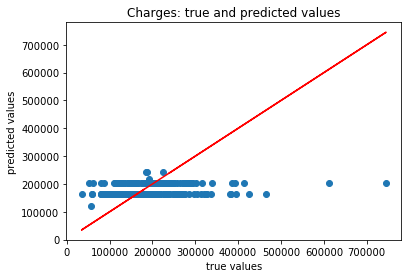

Mean absolute error of the prediction is: 54971.22533825553
Mean squared error of the prediction is: 6347474384.008902
Root mean squared error of the prediction is: 79671.03855234286
Mean absolute percentage error of the prediction is: 33.734138602850635


In [7]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test_w_constant = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test_w_constant)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


# intermideate sumary
Is the performance of your model satisfactory? Why?

- from last check point assignment, we have mentioned that the R-squared value is way to low (close to 0), which indicates that the chosen features are not good to explain the target variable.
- from the predicted-true value plot visulazaiton, the ploted points are far away from the ideal line, which indicated that the prediced value are not matching the actual ones.
- this time, we when ckeck the results from test set, we can see the MAE, MSE, RMSE, MAPE values are high, i.e. MAPE is 33%, so the model is not very satisfactory.


### to fix this, let's include some other features, i.e. 'lotarea', 'yearbuilt'
the result showed that, our new model has higher adjusted R-squared value (0.338), and lower AIC, BIC values. So the new model is a better one. 

In [8]:
# build the linear regression model
# use statsmodels

# Y is the target variable
Y = df_drop['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = df_drop[['lotarea', 'yearbuilt']]


# split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))



X_train_w_constant = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train_w_constant).fit()

results.summary()

# X = sm.add_constant(X)

# results = sm.OLS(Y, X).fit()

# results.summary()

The number of observations in training set is 1168
The number of observations in test set is 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     288.4
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          1.76e-102
Time:                        08:34:36   Log-Likelihood:                -14591.
No. Observations:                1168   AIC:                         2.919e+04
Df Residuals:                    1165   BIC:                         2.920e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.459e+06   1.23e+05    -19.977      0.000    -2.7e+06   -2.22e+06
lotarea        1.9143      0.175     10.914      0.000       1.570       2.258
yearbuilt   1328.7175     62.445     21.278      0.000    1206.199    1451.236
==============================================================================
Omnibus:                      537.023   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3974.861
Skew:                           1.976   Prob(JB):                         0.00
Kurtosis:                      11.127   Cond. No.                     9.91e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

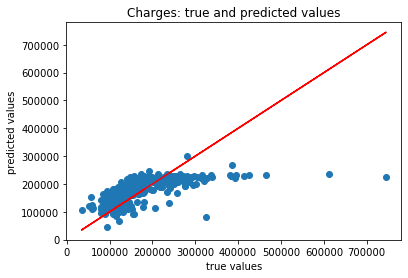

Mean absolute error of the prediction is: 42758.190059963665
Mean squared error of the prediction is: 4258385006.6042933
Root mean squared error of the prediction is: 65256.30242822752
Mean absolute percentage error of the prediction is: 25.01874903370775


In [9]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test_w_constant = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test_w_constant)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


# intermideate sumary
after "Try(ing) to improve your model in terms of predictive performance by adding or removing some variables"

- from the predicted-true value plot visulazaiton, the ploted points are getting closer to ideal line, especially when our target value is lower, which indicated that the model has improved performance.
- we can see that in the test set, MAE, MSE, RMSE and MSPE values decreased, i.e. the MAPE is 25%, which has improved a lot. 

